# Predicting Noise (complaints)
#### Author: Sung Hoon Yang @ NYU

*Below is the abstract of the paper for which the prediction was conducted*

Noise in New York City is increasingly unbearable as evidenced by a growing number of noise complaints, while responses to noise complaints and therefore enforcement of The Noise Code has been hampered due to inability to handle sheer volumes. This capstone project aims to provide a data-driven optimization approach to improve the New York City Department of Environmental Protection’s (DEP) current scheduling process to better address noise complaints. To accomplish this, we will use machine learning to predict noise complaints and qualities that lead to violations for scheduling and routing optimization. Based on our discussion with DEP sponsors and preliminary analysis of 311 complaints, we suspect that our model will improve DEP metrics and that construction-related permits will be of highest variable importance to predicting and determining the validity of noise complaints. The implications of this analysis will allow DEP inspectors to improve time to complaint resolution, vanquish their backlog of complaints, and increase their issuance of violations.

Using publicly available data, we will build a neural network model to predict daily noise complaints per spatial bin as demarcated by Neighborhood Tabulation Areas. In this particular model, I will build a model that predicts the number of daily complaints that pertain to DEP's overseeing per 29 polygons of Manhattan. Below is the complete list of features, followed by that of spatial bins as demarcated by NTA shapefile.


### Features
* **wknd**: Weekend flag
* **holiday**: Holiday flag
* **hours_to_resolution_stdz**: Hours to Resolution standardized annually
* **AWND**: Average daily wind speed (tenths of meters per second)
* **PRCP**: Precipitation (tenths of mm) 
* **SNOW**: Snowfall (mm) 
* **SNWD**: Snow depth (mm) 
* **TMAX**: Maximum temperature (tenths of degrees C)
* **WDF5**: Direction of fastest 5-second wind (degrees)
* **WSF5**: Fastest 5-second wind speed (tenths of meters per second) 
* **d-1_cnt**: Complaint count of D-1
* **d-2_cnt**: Complaint count of D-2
* **d-3_cnt**: Complaint count of D-3
* **d-4_cnt**: Complaint count of D-4
* **d-5_cnt**: Complaint count of D-5
* **d-6_cnt**: Complaint count of D-6
* **d-7_cnt**: Complaint count of D-7
* **d-8_cnt**: Complaint count of D-8
* **d-9_cnt**: Complaint count of D-9
* **d-10_cnt**: Complaint count of D-10
* **d-11_cnt**: Complaint count of D-11
* **d-12_cnt**: Complaint count of D-12
* **d-13_cnt**: Complaint count of D-13
* **d-14_cnt**: Complaint count of D-14
* **d-15_cnt**: Complaint count of D-15
* **d-16_cnt**: Complaint count of D-16
* **d-17_cnt**: Complaint count of D-17
* **d-18_cnt**: Complaint count of D-18
* **d-19_cnt**: Complaint count of D-19
* **d-20_cnt**: Complaint count of D-20
* **d-21_cnt**: Complaint count of D-21
* **d-22_cnt**: Complaint count of D-22
* **d-23_cnt**: Complaint count of D-23
* **d-24_cnt**: Complaint count of D-24
* **d-25_cnt**: Complaint count of D-25
* **d-26_cnt**: Complaint count of D-26
* **d-27_cnt**: Complaint count of D-27
* **d-28_cnt**: Complaint count of D-28
* **ahv_open_cnt**: after hour variance open count
* **WT01**: unknown weather feature (omitted from data dictionary, but included)
* **WT02**: unknown weather feature (omitted from data dictionary, but included)
* **WT04**: unknown weather feature (omitted from data dictionary, but included)
* **WT08**: unknown weather feature (omitted from data dictionary, but included)

### Spatial Bins

* **MN01**:	Marble Hill-Inwood
* **MN03**:	Central Harlem North-Polo Grounds
* **MN04**:	Hamilton Heights
* **MN06**:	Manhattanville
* **MN09**:	Morningside Heights
* **MN11**:	Central Harlem South
* **MN12**:	Upper West Side
* **MN13**:	Hudson Yards-Chelsea-Flatiron-Union Square
* **MN14**:	Lincoln Square
* **MN15**:	Clinton
* **MN17**:	Midtown-Midtown South
* **MN19**:	Turtle Bay-East Midtown
* **MN20**:	Murray Hill-Kips Bay
* **MN21**:	Gramercy
* **MN22**:	East Village
* **MN23**:	West Village
* **MN24**:	SoHo-TriBeCa-Civic Center-Little Italy
* **MN25**:	Battery Park City-Lower Manhattan
* **MN27**:	Chinatown
* **MN28**:	Lower East Side
* **MN31**:	Lenox Hill-Roosevelt Island
* **MN32**:	Yorkville
* **MN33**:	East Harlem South
* **MN34**:	East Harlem North
* **MN35**:	Washington Heights North
* **MN36**:	Washington Heights South
* **MN40**:	Upper East Side-Carnegie Hill
* **MN50**:	Stuyvesant Town-Cooper Village
* **MN99**:	park-cemetery-etc-Manhattan

In [1]:
#torch
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
import gc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
#wrangling
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
import scipy
#dt
import datetime
from dateutil.relativedelta import relativedelta
#user setting
import sys
sys.path.insert(0, './analysis/311/duke')
# precipitation data
from prep_dta import _2010, _2011, _2012, _2013, _2014, _2015, _2016, _2017, _2018
from american_holidays import american_holidays as _american_holidays_str
#viz
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
spatial_dict = {'MN01':'Marble Hill-Inwood','MN03':'Central Harlem North-Polo Grounds','MN04':'Hamilton Heights','MN06':'Manhattanville','MN09':'Morningside Heights','MN11':'Central Harlem South','MN12':'Upper West Side','MN13':'Hudson Yards-Chelsea-Flatiron-Union Square','MN14':'Lincoln Square','MN15':'Clinton','MN17':'Midtown-Midtown South','MN19':'Turtle Bay-East Midtown','MN20':'Murray Hill-Kips Bay','MN21':'Gramercy','MN22':'East Village','MN23':'West Village','MN24':'SoHo-TriBeCa-Civic Center-Little Italy','MN25':'Battery Park City-Lower Manhattan','MN27':'Chinatown','MN28':'Lower East Side','MN31':'Lenox Hill-Roosevelt Island','MN32':'Yorkville','MN33':'East Harlem South','MN34':'East Harlem North','MN35':'Washington Heights North','MN36':'Washington Heights South','MN40':'Upper East Side-Carnegie Hill','MN50':'Stuyvesant Town-Cooper Village','MN99':'park-cemetery-etc-Manhattan',}

In [3]:
features_stdz = pd.read_csv('./features_stdz.csv')
features_stdz.head()

,wknd,holiday,hours_to_resolution_stdz,AWND,PRCP,SNOW,SNWD,TMAX,WDF5,WSF5,WT01,WT02,WT04,WT08,d-1_cnt,d-2_cnt,d-3_cnt,d-4_cnt,d-5_cnt,d-6_cnt,d-7_cnt,d-8_cnt,d-9_cnt,d-10_cnt,d-11_cnt,d-12_cnt,d-13_cnt,d-14_cnt,d-15_cnt,d-16_cnt,d-17_cnt,d-18_cnt,d-19_cnt,d-20_cnt,d-21_cnt,d-22_cnt,d-23_cnt,d-24_cnt,d-25_cnt,d-26_cnt,d-27_cnt,d-28_cnt,ahv_open_cnt
0,1.579233,-0.150566,-0.15404,0.107604,0.207273,-0.093056,7.447692,-1.20886,0.236286,1.105861,1.448874,5.77986,-0.04969,1.93755,-0.054409,-0.678413,-0.365704,-0.052903,-0.364801,-0.676902,-0.676595,-0.051068,-0.362986,-0.050179,-0.362176,-0.674027,-0.673530,-0.673262,-0.672701,-0.046703,-0.359266,-0.671618,-0.671181,-0.357729,-0.357459,-0.670058,-0.669689,-0.355967,-0.355679,-0.668450,-0.668321,-0.668131,-0.50966
1,1.579233,-0.150566,-0.15404,0.107604,0.207273,-0.093056,7.447692,-1.20886,0.236286,1.105861,1.448874,5.77986,-0.04969,1.93755,0.570154,-0.678413,-0.365704,-0.052903,-0.052266,-0.364435,-0.364098,-0.051068,1.199736,-0.675180,2.450534,-0.674027,-0.673530,-0.673262,-0.672701,-0.046703,0.266390,-0.671618,-0.358164,-0.044646,-0.044333,-0.356905,1.209269,-0.669142,-0.355679,-0.668450,-0.041359,-0.668131,-0.50966
2,1.579233,-0.150566,-0.15404,0.107604,0.207273,-0.093056,7.447692,-1.20886,0.236286,1.105861,1.448874,5.77986,-0.04969,1.93755,-0.678973,-0.366098,-0.053309,0.259503,-0.052266,-0.676902,-0.676595,-0.676091,-0.675530,-0.675180,-0.674699,-0.674027,-0.673530,-0.673262,-0.672701,-0.672357,-0.359266,-0.358690,-0.671181,-0.670812,-0.357459,-0.356905,-0.669689,-0.669142,-0.668918,-0.355143,-0.354840,-0.354589,-0.50966
3,1.579233,-0.150566,-0.15404,0.107604,0.207273,-0.093056,7.447692,-1.20886,0.236286,1.105861,1.448874,5.77986,-0.04969,1.93755,-0.054409,-0.053784,-0.365704,-0.365308,-0.052266,-0.364435,-0.676595,-0.363579,-0.362986,-0.675180,-0.362176,-0.674027,-0.360913,-0.047878,-0.672701,-0.359530,-0.046438,-0.671618,0.267869,-0.044646,0.268793,-0.356905,0.582949,-0.042792,-0.355679,-0.668450,-0.668321,-0.668131,-0.50966
4,1.579233,-0.150566,-0.15404,0.107604,0.207273,-0.093056,7.447692,-1.20886,0.236286,1.105861,1.448874,5.77986,-0.04969,1.93755,-0.366691,-0.053784,-0.365704,0.571909,-0.052266,-0.676902,0.260895,-0.676091,-0.675530,2.449824,0.575394,0.576100,-0.048297,0.577505,-0.047187,-0.672357,-0.046438,-0.358690,-0.358164,-0.670812,-0.670585,0.582554,-0.669689,-0.669142,-0.668918,-0.668450,-0.668321,-0.041047,-0.50966


In [4]:
targets_cpu = np.loadtxt('./targets.txt')

In [5]:
targets_cpu[0]

array([ 1.,  3.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,
        0.,  0.,  0.,  3.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.])

### Inspect Hessian

I am using MSELoss. Below shows that covariance matrix is essentially the Hessian of the Loss function. 

$$
\begin{align}
\text{MSE} &= \frac{1}{N}||W\vec{x} - \vec{y}||^2 \quad \hat{y} :=W\vec{x}\\
\nabla_{W} \text{MSE} &= \frac{2}{N} ||W\vec{x} - \vec{y}||\vec{x}^T \\
\nabla_{W}^2 \text{MSE} &= \frac{1}{N} 2\vec{x}\vec{x}^T \\
\end{align}
$$

Let us examine the covariance matrix of the features.

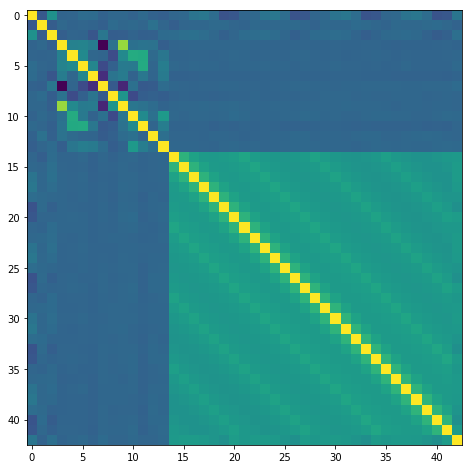

In [6]:
fig = plt.figure(figsize=(8, 8))
plt.clf()
plt.imshow(features_stdz.corr())

If the covariance matrix diverges from Identity, some eigenvectors may have a small magnitude, collapsing the corresponding axis of the Loss space. But, it's okay if you use `SGD` with a small learning rate, because you cannot examine the entire Hypothesis space. If repeated predictions result in similar minimization, we can be confident that it is close tothe global minimum.

In [7]:
# Measure sizes
features = np.array(features_stdz)
S = 29
T = int(features.shape[0] / S)
Fe=features.shape[1]
H=Fe*S//4
batch_size=1
num_epochs = 40

features_nn = features.reshape(T, S*Fe)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    features_nn
    , targets_cpu
    , test_size=0.2
    , shuffle=False
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1624, 1247), (406, 1247), (1624, 29), (406, 29))

In [9]:
dev_cnt = torch.cuda.device_count()

train_ds = DataLoader(
    torch.from_numpy(np.concatenate((X_train, y_train), axis=1))
    , batch_size=batch_size
    , drop_last=True
    , shuffle=True
    , num_workers=dev_cnt*6
    , pin_memory=True
)

test_ds = DataLoader(
    torch.from_numpy(np.concatenate((X_test, y_test), axis=1))
    , batch_size=batch_size
    , drop_last=True    
    , num_workers=dev_cnt*6
    , pin_memory=True    
)

In [10]:
# Here we define our model as a class
class ManhattanModel(nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, output_dim, num_layers, batch_size):
        """
        The model uses LSTM model as both Encoder/Decoder for this undercomplete Autoencoder model.
        * Batch normalization is used for all linear layers.
        * The autoencoder compresses the representation to hidden_dim/4, 
            and then recovers the dimensionality back to hidden_dim
        * Softmax layer is used to output pseudo-probability density of complaint volume 
            of each spatial bin on each day.
        """
        super(ManhattanModel, self).__init__()
        self.input_dim = input_dim
        self.feature_dim = feature_dim        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim        
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(
            input_dim*feature_dim
            , self.hidden_dim
            , self.num_layers
            , dropout=0.1
            , batch_first=True
        )
        self.batchnorm1d_1 = nn.BatchNorm1d(batch_size)            
        self.linear_1 = nn.Linear(self.hidden_dim, int(self.hidden_dim/2))
        self.batchnorm1d_2 = nn.BatchNorm1d(batch_size)   
        self.linear_2 = nn.Linear(int(self.hidden_dim/2), int(self.hidden_dim/4))
        self.lstm2 = nn.LSTM(
            int(self.hidden_dim/4)
            , self.hidden_dim
            , self.num_layers
            , dropout=0.1
            , batch_first=True
        )
        self.batchnorm1d_3 = nn.BatchNorm1d(batch_size)    
        self.linear_3 = nn.Linear(self.hidden_dim, int(self.hidden_dim/2))
        self.batchnorm1d_4 = nn.BatchNorm1d(batch_size)    
        self.linear_4 = nn.Linear(int(self.hidden_dim/2), output_dim)        
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, x, h1, h2):
        if h1 is None:
            x, h1 = self.lstm1(x)
        else:
            x, h1 = self.lstm1(x, h1)
        x = self.batchnorm1d_1(x)
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.batchnorm1d_2(x)
        x = self.linear_2(x)   
        x = F.relu(x)        
        if h2 is None:
            x, h2 = self.lstm2(x)
        else:
            x, h2 = self.lstm2(x, h2)
        x = self.linear_3(x)  
        x = self.batchnorm1d_3(x)
        x = F.relu(x)        
        x = self.batchnorm1d_4(x)
        x = self.linear_4(x)  
        x = F.relu(x)  
        x = F.softmax(x, dim=-1)
        return x, h1, h2
    


In [11]:
gc.collect()
torch.cuda.empty_cache()

model_s = ManhattanModel(S, Fe, H, S, 1, batch_size)
# model_s = ManhattanDenseNet(S, Fe, H, S, 2, batch_size)

model = nn.DataParallel(model_s, device_ids=range(dev_cnt)) #I want to use all available GPUs anyhow
# model = model.cuda()
model.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5)
losses = []


/home/shy256/pyenv/py3.6.3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [12]:
d = torch.load('/scratch/shy256/capstone/cs_lstm_L1_AEDE_SM.pth')

model.load_state_dict(d)

model.eval()
losses = []
preds = []
targets = []
c_1, c_2 = None, None


with torch.no_grad():
    for batch_idx, data in enumerate(test_ds):
        X_test_bf = data[:, :Fe*S].reshape(1, batch_size, Fe*S).type(torch.cuda.FloatTensor)
        y_test_bf = data[:, Fe*S:].type(torch.cuda.FloatTensor)
        output, c_1, c_2 = model(X_test_bf, c_1, c_2)
        collapsed_size = torch.tensor(y_test_bf.shape).cumprod(dim=0)[-1].item()
        pred = output.view(collapsed_size)
        preds.extend(pred)
        target = F.softmax(y_test_bf.view(collapsed_size))
        targets.extend(target)        
        loss = loss_fn(
            pred.squeeze()
            , target.squeeze()
        )
        losses.append(loss.item())
        loss_t = np.mean(losses[-1:])
        print(
            '[test] [b]:%s - [loss]:%s' \
            % (batch_idx, str(loss_t))
        )

/home/shy256/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[test] [b]:0 - [loss]:0.0124927004799
[test] [b]:1 - [loss]:0.0267216581851
[test] [b]:2 - [loss]:0.0273507181555
[test] [b]:3 - [loss]:0.00980117078871
[test] [b]:4 - [loss]:0.00948901008815
[test] [b]:5 - [loss]:0.0115746073425
[test] [b]:6 - [loss]:0.00290232221596
[test] [b]:7 - [loss]:0.0243801716715
[test] [b]:8 - [loss]:0.0351493507624
[test] [b]:9 - [loss]:0.0341621488333
[test] [b]:10 - [loss]:0.0218577198684
[test] [b]:11 - [loss]:0.00701396213844
[test] [b]:12 - [loss]:0.0185701455921
[test] [b]:13 - [loss]:0.0102488696575
[test] [b]:14 - [loss]:0.0293127130717
[test] [b]:15 - [loss]:0.0352380909026
[test] [b]:16 - [loss]:0.0200921948999
[test] [b]:17 - [loss]:0.00512331863865
[test] [b]:18 - [loss]:0.0100087095052
[test] [b]:19 - [loss]:0.00175111589488
[test] [b]:20 - [loss]:0.0033907557372
[test] [b]:21 - [loss]:0.0102584287524
[test] [b]:22 - [loss]:0.0299352221191
[test] [b]:23 - [loss]:0.0252590794116
[test] [b]:24 - [loss]:0.0184788480401
[test] [b]:25 - [loss]:0.0356

In [20]:
target_vals_orig = np.array(targets).reshape(len(targets) // 29, 29)
pred_vals_orig = np.array(preds).reshape(len(targets) // 29, 29)


In [21]:
target_vals = target_vals_orig.copy()
pred_vals = pred_vals_orig.copy()



In [ ]:
import matplotlib.dates as mdates

plt.clf()
dts = pd.date_range(
    datetime.datetime.strptime("2017-08-27", '%Y-%m-%d') - relativedelta(days=len(losses) - 1)
    , datetime.datetime.strptime("2017-08-27", '%Y-%m-%d')
)
dts_str = [datetime.datetime.strftime(dt, '%Y-%m-%d') for dt in dts]
mn_nms = ["MN14" , "MN31" , "MN32" , "MN12" , "MN20" , "MN23" , "MN24" , "MN01" , "MN03" , "MN09" , "MN13" , "MN22" , "MN25" , "MN27" , "MN36" , "MN17" , "MN19" , "MN21" , "MN28" , "MN33" , "MN15" , "MN35" , "MN40" , "MN11" , "MN04" , "MN34" , "MN06" , "MN99" , "MN50"]

fig, axs = plt.subplots(
    S * 2 + 2, 1, figsize=(16, 80)
)
# plt.subplots_adjust(bottom=0.9, top=1)
axs[0].plot(dts, target_vals.sum(axis=1), label='target')
axs[0].plot(dts, pred_vals.sum(axis=1), label='prediction')
tot_avg = target_vals.sum(axis=1).astype(np.float64).mean()
tot_std = target_vals.sum(axis=1).astype(np.float64).std()
axs[0].set_ylabel(f'Total\nm:{tot_avg:.1f}\nstdev:{tot_std:.1f}')
# axs[1].plot(dts, losses)

tot_acc = np.array(torch.Tensor((pred_vals.sum(axis=1) / target_vals.sum(axis=1)).astype(np.float64)).cpu())
axs[1].plot(
    dts, tot_acc * 100, color='g', label='score'    
)
axs[1].set_ylim(0, 100)
axs[1].set_ylabel('Score') 
axs[1].bar(dts, tot_acc * 100, 1.1, color='g')
axs[1].bar(dts, 100-tot_acc*100, 1.1, bottom=tot_acc * 100, color='r')

losses = np.array(losses)
loss_avg = losses.mean()
loss_std = losses.std()
axs[1].set_ylabel('Score')

for i in range(0, S):
    if i == 15:
        break
    # replace zero with the mean to make the prediction accuracy graph look better
    index_both_zero = list(set(np.where(target_vals[:,i].astype(np.float64) == 0)[0]) & set(np.where(pred_vals[:,i].astype(np.float64) < 5e-1)[0]))
    np.put(target_vals[:,i], index_both_zero, [1] * len(index_both_zero))
    np.put(pred_vals[:,i], index_both_zero, [1] * len(index_both_zero))
    # if target of pred is zero and the other is not, assign 0.5 to coerce to accuracy
    target_vals[:,i][target_vals[:,i] <= 8e-1] = 1e-5
    pred_vals[:,i][pred_vals[:,i] <= 8e-1] = 1e-5
    denom = np.max(np.array([target_vals[:,i], pred_vals[:,i]]), axis=0)
    numer = np.min(np.array([target_vals[:,i], pred_vals[:,i]]), axis=0)
    acc = np.array(torch.Tensor((numer / denom).astype(np.float64)).cpu())
    t, p, nm = target_vals[:,i].astype(np.float64), pred_vals[:,i].astype(np.float64), mn_nms[i]
    i *= 2
    i += 2    
    axs[i].plot(
        dts, t, 'r-'
        , dts, p, 'b-'
    )
    cnt_avg = t.mean()
    pred_cnt_avg = p.mean()    
    cnt_std = t.std()    
    pred_cnt_std = p.std()       
    axs[i].set_ylabel(spatial_dict[nm].replace(' ', '\n') + f'\nm:{cnt_avg:.1f}/{pred_cnt_avg:.1f}\nstdev:{cnt_std:.1f}/{pred_cnt_std:.1f}')
    acc[~np.isfinite(acc)] = 0
    axs[i + 1].plot(
        dts, acc * 100, color='g', label='score'    
    )
    axs[i + 1].set_ylim(0, 100)
    axs[i + 1].set_ylabel('Score') 
    axs[i + 1].bar(dts, acc * 100, 1.1, color='g')
    axs[i + 1].bar(dts, 100-acc*100, 1.1, bottom=acc * 100, color='r')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.05)
plt.savefig('./test_result_b1-shuf_manhattan_dn.png')
# plt.show()

In [ ]:
target_vals = target_vals_orig.copy()
pred_vals = pred_vals_orig.copy()



In [ ]:
# see if I can do better by using the aggregate ranking
static_ranking = np.flip(
    np.array(list([spatial_dict[k] for k in mn_nms]))[np.argsort(target_vals.sum(axis=0).astype(np.float64))], 0)[:15]
static_ranking

In [ ]:
# Check the frequentists of the Model's Dynamic Ranking
a = []
[a.extend(list(frozenset(np.flip(np.array(list([spatial_dict[k] for k in mn_nms]))[np.argsort(target_vals[II].astype(np.float64))], 0)[:15]))) for II in range(0, 200)]

pd.Series(a).unique()


In [ ]:
A = []
static_ranking_arr = []
for i in range(406):
    v = len(list(set(np.flip(np.array(list([spatial_dict[k] for k in mn_nms]))[np.argsort(target_vals[i].astype(np.float64))], 0)[:15]) & \
set(np.flip(np.array(list([spatial_dict[k] for k in mn_nms]))[np.argsort(pred_vals[i].astype(np.float64))], 0)[:15]))) / 15
    A.append(v)
    v = len(list(set(np.flip(np.array(list(spatial_dict.values()))[np.argsort(target_vals[i].astype(np.float64))], 0)[:15]) & \
set(static_ranking))) / 15
    static_ranking_arr.append(v)


fig, axs = plt.subplots(1, 2, figsize=(16, 4))
A = np.array(A)
axs[0].plot(A, color='#afeeee')
model_mean = np.array(A).mean()
axs[0].set_title(f'Prediction with Model\nmean accuracy: {model_mean:.3f}')
axs[0].set_ylim(0, 1)
axs[0].set_xlabel('Days')
axs[0].set_ylabel('Score')
axs[0].bar(np.arange(A.size), A, 1.1, color='#afeeee')
axs[0].bar(np.arange(A.size), 1-A, 1.1, bottom=A, color='magenta')



static_ranking_arr = np.array(static_ranking_arr)
axs[1].plot(static_ranking_arr, color='#afeeee')
static_ranking_mean = np.array(static_ranking_arr).mean()
axs[1].set_title(f'Prediction with Static Ranking\nmean accuracy: {static_ranking_mean:.3f}')
axs[1].set_ylim(0, 1)
axs[1].set_xlabel('Days')
axs[1].set_ylabel('Score')
axs[1].bar(np.arange(static_ranking_arr.size), static_ranking_arr, 1.1, color='#afeeee')
axs[1].bar(np.arange(static_ranking_arr.size), 1-static_ranking_arr, 1.1, bottom=static_ranking_arr, color='magenta')

# Bibliography

Menne, M.J., I. Durre, R.S. Vose, B.E. Gleason, and T.G. Houston, 2012:  An overview 
of the Global Historical Climatology Network-Daily Database.  Journal of Atmospheric 
and Oceanic Technology, 29, 897-910, doi:10.1175/JTECH-D-11-00103.1.